In [ ]:
# ⚙️ Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [ ]:
# 📁 Paths and Constants
Train_Path = "/content/drive/MyDrive/Project/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/train"
Val_Path = "/content/drive/MyDrive/Project/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/val"
Test_Path = "/content/drive/MyDrive/Project/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test"

IMG_SIZE = (128, 128)           # smaller image size for speed
BATCH_SIZE = 16                 # smaller batch size to reduce memory
EPOCHS_CNN = 5
EPOCHS_PRETRAINED = 3
BEST_MODEL_PATH = "/content/drive/MyDrive/Project/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/best_fish_model.keras"

In [ ]:
# 🧼 Data Preprocessing and Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(Train_Path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(Val_Path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(Test_Path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 6285 images belonging to 11 classes.
Found 1112 images belonging to 11 classes.
Found 3197 images belonging to 11 classes.


In [ ]:
# 🧠 CNN Model
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(train_gen.class_indices), activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# 🧠 Pretrained Model Builder
def create_pretrained_model(name):
    base_models = {
        "VGG16": VGG16,
        "ResNet50": ResNet50,
        "MobileNet": MobileNet,
        "InceptionV3": InceptionV3,
        "EfficientNetB0": EfficientNetB0
    }
    base_model = base_models[name](weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_model.trainable = False  # freeze all layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(train_gen.class_indices), activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# 🧪 Training Loop

models = {"CNN": create_cnn_model()}
for name in ["VGG16", "ResNet50", "MobileNet", "InceptionV3", "EfficientNetB0"]:
    models[name] = create_pretrained_model(name)

best_model = None
best_accuracy = 0
history_dict = {}
metrics_dict = {}

for name, model in models.items():
    print(f"\n🔁 Training {name}...")

    # Define callbacks
    checkpoint = ModelCheckpoint(BEST_MODEL_PATH, save_best_only=True, monitor='val_accuracy', mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS_CNN if name == 'CNN' else EPOCHS_PRETRAINED,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )

    # Store training history
    history_dict[name] = history.history

    # Evaluate the model
    y_true = val_gen.classes
    y_pred = np.argmax(model.predict(val_gen), axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    metrics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision_score(y_true, y_pred, average='macro', zero_division=1),
        "Recall": recall_score(y_true, y_pred, average='macro', zero_division=1),
        "F1 Score": f1_score(y_true, y_pred, average='macro', zero_division=1),
        "Confusion Matrix": confusion_matrix(y_true, y_pred)
    }

    # Track best performing model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model


🔁 Training CNN...
Epoch 1/5
393/393 ━━━━━━━━━━━━━━━━━━━━ 1590s 4s/step - accuracy: 0.3126 - loss: 1.9827 - val_accuracy: 0.6259 - val_loss: 1.0829
Epoch 2/5
393/393 ━━━━━━━━━━━━━━━━━━━━ 132s 335ms/step - accuracy: 0.5579 - loss: 1.2196 - val_accuracy: 0.7446 - val_loss: 0.8119
Epoch 3/5
393/393 ━━━━━━━━━━━━━━━━━━━━ 138s 323ms/step - accuracy: 0.6577 - loss: 0.9286 - val_accuracy: 0.8165 - val_loss: 0.6049
Epoch 4/5
393/393 ━━━━━━━━━━━━━━━━━━━━ 131s 332ms/step - accuracy: 0.7187 - loss: 0.8195 - val_accuracy: 0.8291 - val_loss: 0.4952
Epoch 5/5
393/393 ━━━━━━━━━━━━━━━━━━━━ 127s 323ms/step - accuracy: 0.7652 - loss: 0.6695 - val_accuracy: 0.7914 - val_loss: 0.5378
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step

🔁 Training VGG16...
Epoch 1/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 943s 2s/step - accuracy: 0.3728 - loss: 1.8393 - val_accuracy: 0.7203 - val_loss: 1.0105
Epoch 2/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 975s 2s/step - accuracy: 0.6657 - loss: 1.0131 - val_accuracy: 0.8246 - val_loss: 0.6914
Epoch 3/3


In [ ]:
# 💾 Save Best Model and Metrics
if best_model:
    best_model.save(BEST_MODEL_PATH)
    joblib.dump(metrics_dict, "model_metrics.pkl")

In [ ]:
# 📊 Performance Summary
metrics_df = pd.DataFrame.from_dict(
    {model: {k: v for k, v in metrics_dict[model].items() if k != "Confusion Matrix"} for model in metrics_dict},
    orient='index'
)
print("\n📈 Model Performance:\n", metrics_df)


📈 Model Performance:
                 Accuracy  Precision    Recall  F1 Score
CNN             0.109712   0.185000  0.094468  0.093258
VGG16           0.104317   0.176644  0.089494  0.086346
ResNet50        0.133094   0.530398  0.088674  0.039547
MobileNet       0.111511   0.102413  0.102668  0.102396
InceptionV3     0.103417   0.183751  0.093105  0.092639
EfficientNetB0  0.168165   0.924379  0.090909  0.026174


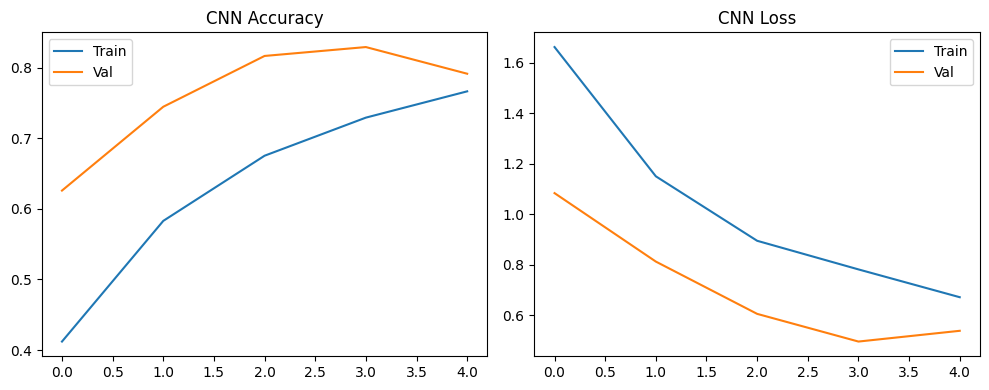

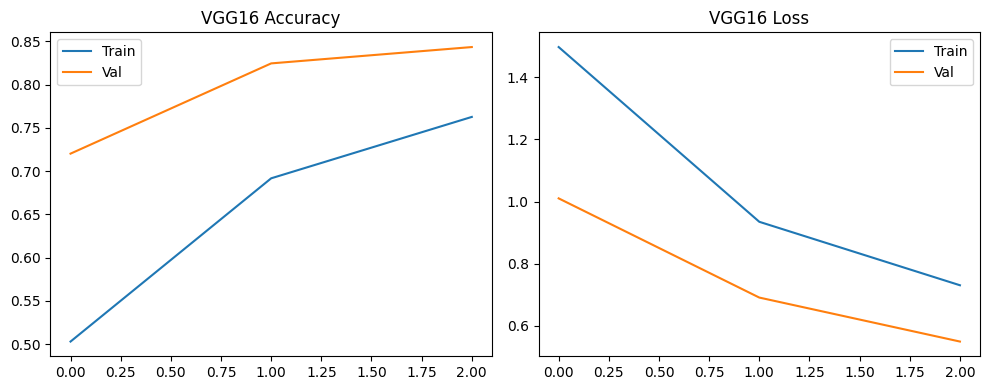

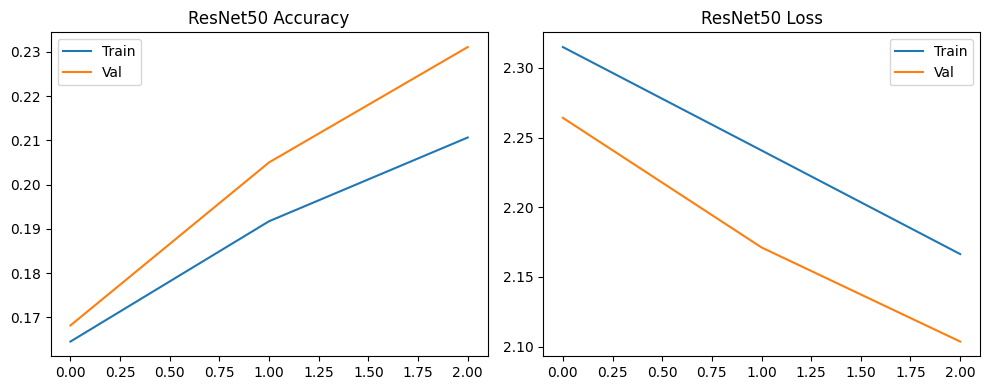

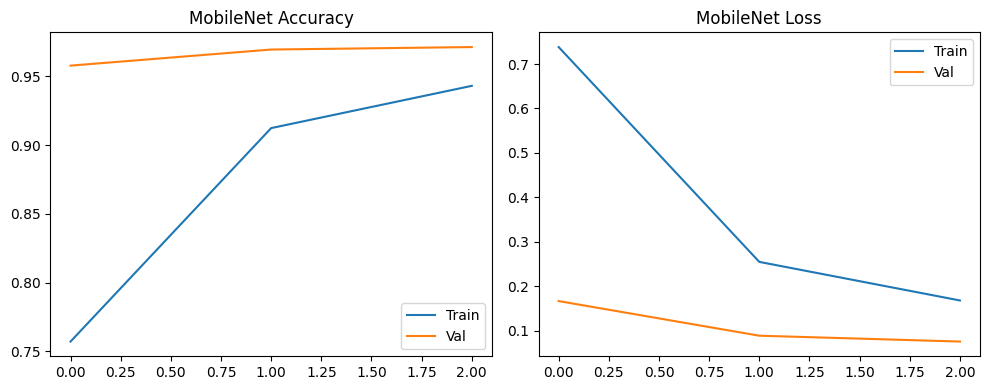

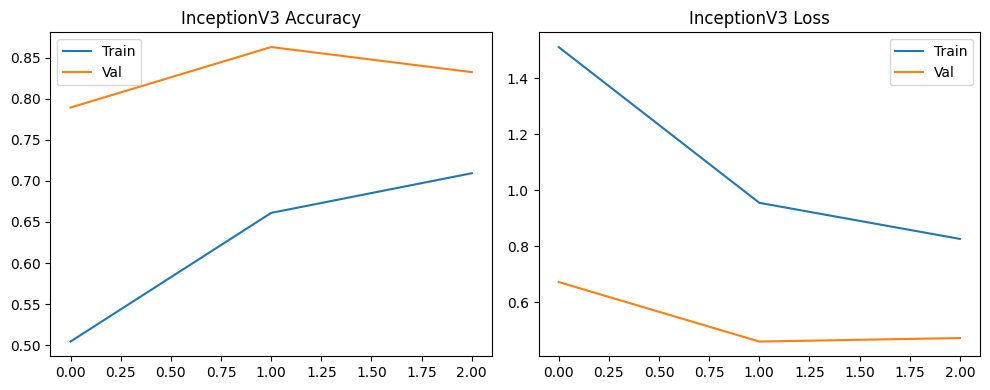

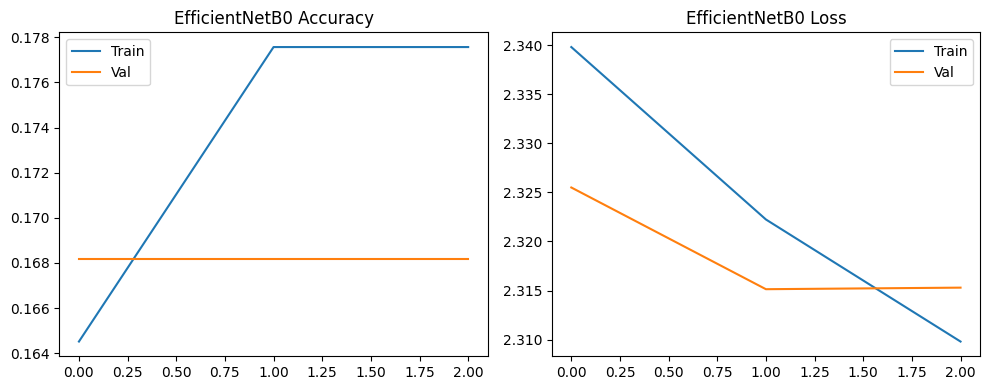

In [ ]:
# 📉 Accuracy & Loss Plots
for name, history in history_dict.items():
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train')
    plt.plot(history['val_accuracy'], label='Val')
    plt.title(f"{name} Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title(f"{name} Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 717s 4s/step


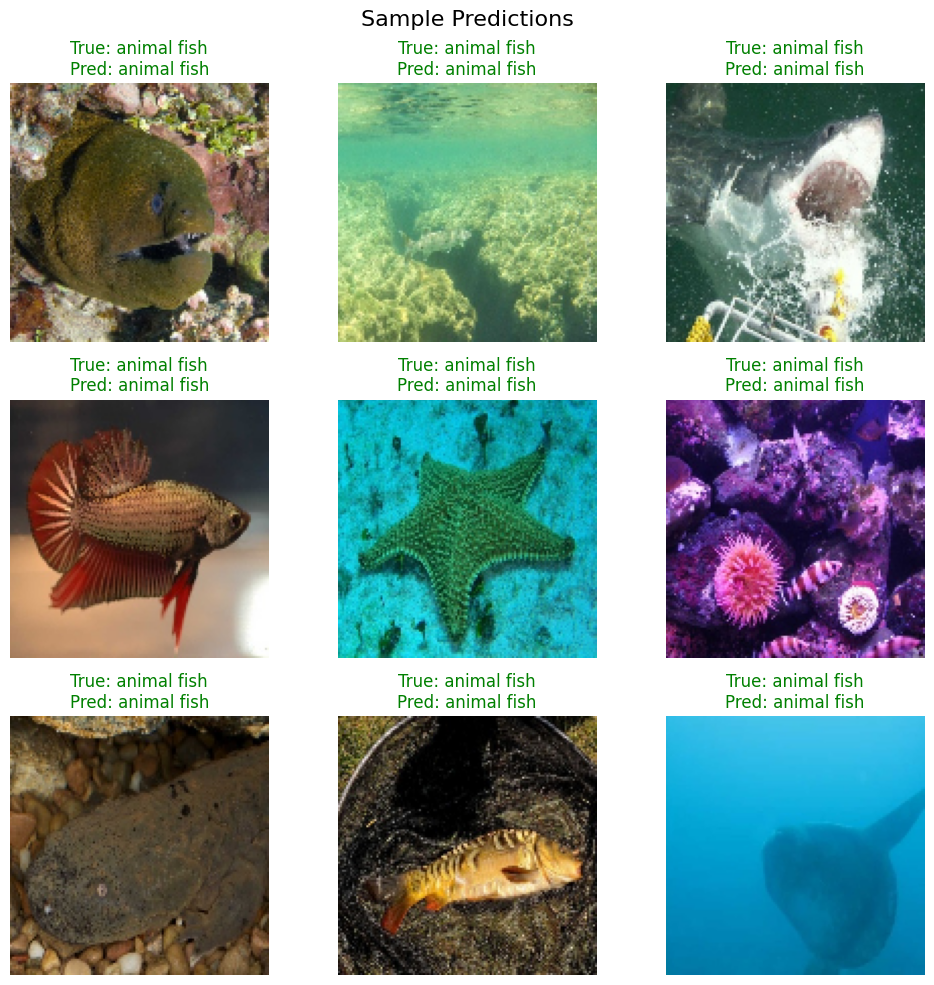

In [ ]:
# 🖼️ Sample Predictions
model = load_model(BEST_MODEL_PATH)
class_labels = list(test_gen.class_indices.keys())
test_images, test_labels = next(test_gen)
test_preds = np.argmax(model.predict(test_gen), axis=1)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Sample Predictions", fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i])
    true_label = class_labels[np.argmax(test_labels[i])]
    pred_label = class_labels[test_preds[i]]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color='green' if true_label == pred_label else 'red')
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# 🧾 Classification Report
y_true = test_gen.classes
y_pred_proba = model.predict(test_gen)
y_pred = np.argmax(y_pred_proba, axis=1)

print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=1))

200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step

📋 Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       1.00      0.00      0.00        13
   fish sea_food black_sea_sprat       1.00      0.00      0.00       298
   fish sea_food gilt_head_bream       1.00      0.00      0.00       315
   fish sea_food hourse_mackerel       1.00      0.00      0.00       286
        fish sea_food red_mullet       1.00      0.00      0.00       291
     fish sea_food red_sea_bream       1.00      0.00      0.00       273
          fish sea_food sea_bass       1.00      0.00      0.00       327
            fish sea_food shrimp       1.00      0.00      0.00       289
fish sea_food striped_red_mullet       1.00      0.00      0.00       293
             fish sea_food trout       1.00      0.00      0.00       292

                        accuracy       

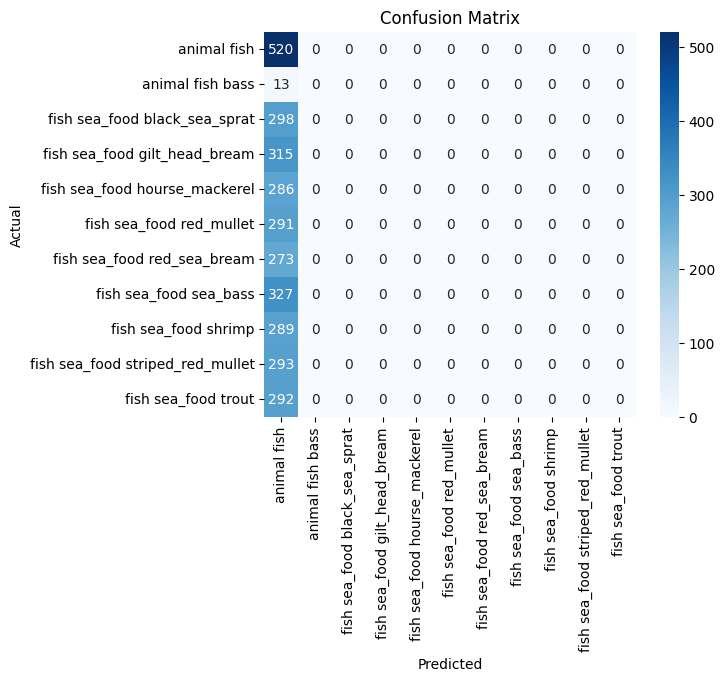

In [ ]:
# 🔵 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

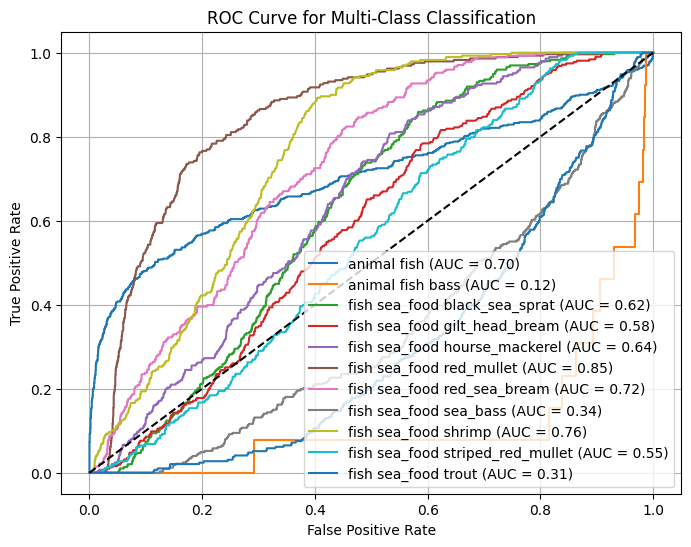

In [ ]:
# 🧠 ROC Curve (Optional)
y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc='lower right')
plt.grid()
plt.show()